In [4]:
%matplotlib inline
from __future__ import print_function, absolute_import

import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pydrake.all import (
    DiagramBuilder,
    FloatingBaseType,
    RigidBodyTree,
    RigidBodyPlant,
    SignalLogger, 
    Simulator, 
    VectorSystem
)
# from pydrake.examples.pendulum import PendulumPlant
from pydrake.systems.controllers import (
    DynamicProgrammingOptions, FittedValueIteration, PeriodicBoundaryCondition)
from visualizer import PendulumVisualizer
# from pydrake.examples.acrobot import AcrobotPlant
from underactuated import (
    PlanarRigidBodyVisualizer
)

In [2]:
tree = RigidBodyTree("/opt/underactuated/src/cartpole/cartpole.urdf",
                     FloatingBaseType.kFixed)
plant = RigidBodyPlant(tree)

simulator = Simulator(plant)
options = DynamicProgrammingOptions()

# State: (theta1, theta2, theta1_dot, theta2_dot) Input: Elbow torque

def min_time_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    u = plant.EvalVectorInput(context, 0).CopyToVector()
    x[1] = x[1] - math.pi
    if x.dot(x) < .1: # seeks get x to (0., math.pi, 0., 0.)
        return 0.
    return 1. + 2*x.dot(x)/(10**2+math.pi**2+10**2+math.pi**2) + u.dot(u)/(180**2)


def quadratic_regulator_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    x[1] = x[1] - math.pi
    u = plant.EvalVectorInput(context, 0).CopyToVector()
#     return 2*x.dot(x)/(10**2+math.pi**2+10**2+math.pi**2) + u.dot(u)/(180**2)
    return 2*x.dot(x)/(10**2+math.pi**2+10**2+math.pi**2) + u.dot(u)/(180)


if (True):
    cost_function = min_time_cost
    input_limit = 180.
    options.convergence_tol = 0.001
#     options.convergence_tol = 0.003
    state_steps = 19
    input_steps = 19
else:
    cost_function = quadratic_regulator_cost
    input_limit = 250.
    options.convergence_tol = 0.01
    state_steps = 19
    input_steps = 19

####### SETTINGS ####### My cartpole linspaces are off??????
# State: (x, theta, x_dot, theta_dot)
# Previous Best... (min. time) (3)
xbins = np.linspace(-10., 10., state_steps)
thetabins = np.hstack((np.linspace(0., math.pi-0.2, 8), np.linspace(math.pi-0.2, math.pi+0.2, 11), np.linspace(math.pi+0.2, 8, 2*math.pi)))
xdotbins = np.linspace(-10., 10., state_steps)
thetadotbins = np.linspace(-10., 10., state_steps)
timestep = 0.01

# Test 1 (4)
xbins = np.linspace(-10., 10., state_steps)
thetabins = np.hstack((np.linspace(0., math.pi-0.12, 8), np.linspace(math.pi-0.12, math.pi+0.12, 11), np.linspace(math.pi+0.12, 8, 2*math.pi)))
xdotbins = np.linspace(-10., 10., state_steps+2)
thetadotbins = np.hstack((np.linspace(-10., -1.5, 9), np.linspace(-1.5, 1.5, 11), np.linspace(1.5, 10., 9)))
# timestep = 0.001 <- wasn't active...

# Test 2 - Test 1 was worse? WOW I HAD A BUG! - in my last np.linspace  (5) SWEET!!!
xbins = np.linspace(-10., 10., state_steps)
thetabins = np.hstack((np.linspace(0., math.pi-0.2, 10), np.linspace(math.pi-0.2, math.pi+0.2, 9), np.linspace(math.pi+0.2, 2*math.pi, 10)))
xdotbins = np.linspace(-10., 10., state_steps+2)
thetadotbins = np.linspace(-10., 10., state_steps)
timestep = 0.01
input_limit = 250. # test_stabilize_top7 for the higher input_limit version

# Test 3 - Let's try increasing the state and penalty costs a bit more? (6)
# xbins = np.linspace(-10., 10., state_steps)
# thetabins = np.hstack((np.linspace(0., math.pi-0.2, 10), np.linspace(math.pi-0.2, math.pi+0.2, 11), np.linspace(math.pi+0.2, 2*math.pi, 10)))
# xdotbins = np.linspace(-10., 10., state_steps+2)
# thetadotbins = np.linspace(-10., 10., state_steps)
# timestep = 0.01
# def my_cost(context):
#     x = context.get_continuous_state_vector().CopyToVector()
#     u = plant.EvalVectorInput(context, 0).CopyToVector()
#     x[1] = x[1] - math.pi
#     if x.dot(x) < .1: # seeks get x to (math.pi, 0., 0., 0.) # I should really try to get rid of this if statement from my cost function...
#         return 0.
#     return 1. + x.dot(x)/10 + u.dot(u)/1000 # About 20x increase in both constants...
# cost_function = my_cost

# Test 4, let's try doing just quadratic cost, all other settings the same.

# Test log:
# 1) Adding more data points to middle of thetadot range to try and stabilize the upright position more...?
# 2) Also added some state_steps...


options.periodic_boundary_conditions = [
    PeriodicBoundaryCondition(1, 0., 2.*math.pi),
]
state_grid = [set(xbins), set(thetabins), set(xdotbins), set(thetadotbins)]
input_grid = [set(np.linspace(-input_limit, input_limit, input_steps))] # Input: x force
# timestep = 0.01

# [Q, Qdot] = np.meshgrid(xbins, thetabins)
# # [Q, Qdot] = np.meshgrid(qbins, qbins2)
# # [Q, Qdot] = np.meshgrid(qbins, qbins2, qdotbins, qdotbins2)
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.set_xlabel("theta")
# ax.set_ylabel("thetadot")

# fig2 = plt.figure()
# ax2 = fig2.gca(projection='3d')
# ax2.set_xlabel("q")
# ax2.set_ylabel("qdot")


# def draw(iteration, mesh, cost_to_go, policy):
#     # Drawing is slow, don't draw every frame.
#     if iteration % 10 != 0:
#         return
#     plt.title("iteration " + str(iteration))
#     J = np.reshape(cost_to_go, Q.shape)
#     surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
#                            cmap=cm.jet)

#     Pi = np.reshape(policy, Q.shape)
#     surf2 = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1, cmap=cm.jet)

#     display.display(plt.gcf())
#     display.clear_output(wait=True)


# options.visualization_callback = draw

policy, cost_to_go = FittedValueIteration(simulator, cost_function,
                                          state_grid, input_grid,
                                          timestep, options)


/home/rverkuil/integration/integration/lib/python2.7/site-packages/ipykernel_launcher.py:45: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
/home/rverkuil/integration/integration/lib/python2.7/site-packages/ipykernel_launcher.py:52: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


In [9]:
from pydrake.all import (BarycentricMesh, BarycentricMeshSystem)
def save_policy(name): # binds to policy, state_grid, and cost_to_go
    output_values = policy.get_output_values()
    np.save('numpy_saves/pi_b_mesh_init__cartpole_'+name, state_grid)
    np.save('numpy_saves/pi_output_values__cartpole_'+name, output_values)
    np.save('numpy_saves/ctg__cartpole_'+name, cost_to_go)
def load_policy(name):
    b_mesh_init = np.load('numpy_saves/pi_b_mesh_init__cartpole_'+name+'.npy').tolist()
    output_values = np.load('numpy_saves/pi_output_values__cartpole_'+name+'.npy')
    b_mesh = BarycentricMesh(b_mesh_init)
    ctg = np.load('numpy_saves/ctg__cartpole_'+name+'.npy')
    return BarycentricMeshSystem(b_mesh, output_values), ctg
# save_policy('test_stabilize_top7_w_ctg')
policy, ctg = load_policy('test_stabilize_top7_w_ctg')

In [10]:
# Animate the resulting policy.
builder = DiagramBuilder()
tree = RigidBodyTree("/opt/underactuated/src/cartpole/cartpole.urdf",
                     FloatingBaseType.kFixed)
plant = RigidBodyPlant(tree)
plant_system = builder.AddSystem(plant)


# TODO(russt): add wrap-around logic to barycentric mesh
# (so the policy has it, too)
class WrapTheta(VectorSystem):
    def __init__(self):
        VectorSystem.__init__(self, 4, 4)

    def _DoCalcVectorOutput(self, context, input, state, output):
        output[:] = input
        twoPI = 2.*math.pi
        output[1] = output[1] - twoPI * math.floor(output[1] / twoPI)


wrap = builder.AddSystem(WrapTheta())
builder.Connect(plant_system.get_output_port(0), wrap.get_input_port(0))
# vi_policy = builder.AddSystem(test)
vi_policy = builder.AddSystem(policy)
builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
builder.Connect(vi_policy.get_output_port(0), plant_system.get_input_port(0))

logger = builder.AddSystem(SignalLogger(4))
logger._DeclarePeriodicPublish(0.033333, 0.0)
builder.Connect(plant_system.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)

state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
state.SetFromVector([-1., math.pi-1, 1., -1.])

In [11]:
simulator.StepTo(10.)

In [12]:
# Visualize the result as a video.
# vis = PendulumVisualizer()
vis = PlanarRigidBodyVisualizer(tree, xlim=[-12.5, 12.5], ylim=[-1, 2.5])
ani = vis.animate(logger, repeat=True)

# plt.show()λ 
# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())

/home/rverkuil/integration/integration/local/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


## Let's verify the cost to go against cost of many random (w/ random inits) dircols!

In [26]:
from pydrake.all import (
    BarycentricMesh,
    DirectCollocation, 
    PiecewisePolynomial, 
    SolutionResult,
)
from traj.vi_utils import do_dircol_cartpole


def do_dircol(ic, warm_start="linear", seed=1776, should_vis=False):
    return do_dircol_cartpole(ic           = ic, 
                       warm_start   = warm_start, 
                       seed         = seed, 
                       should_vis   = should_vis)#,
#                        num_samples  = 42, 
#                        min_timestep = 0.2, 
#                        max_timestep = 0.21)

In [28]:
%matplotlib notebook


from pydrake.all import (SolutionResult)

# Gen a bunch of random initial conditions
n = 3
xs = np.random.uniform(-10, 10, n)
thetas = np.random.uniform(0, 2*math.pi, n)
xdots = np.random.uniform(-10, 10, n)
thetadots = np.random.uniform(-10, 10, n)
# ics = zip(xs, x_dots)
ics = [(x, theta, xdot, thetadot) for x in xs for theta in thetas for xdot in xdots for thetadot in thetadots]
print(ics)
# from traj.vi_utils import (do_dircol_pendulum)

def eval_policy(x):
    mesh = policy.get_mesh()
    ovs  = policy.get_output_values()
    return mesh.Eval(ovs, x)
def eval_ctg(x):
    bary_cost_to_go = BarycentricMesh(state_grid)
    return bary_cost_to_go.Eval(cost_to_go.reshape(1, -1), np.array(x))

# Do dircol from them
good_ics = [] # TODO: remove?
# J = np.reshape(cost_to_go, Q.shape)
found_values, expected_values = [], []
SSE = 0
for i, ic in enumerate(ics):
    # TODO: turn on the random initializations!!
#     if i % 50 == 0:
    print("{} ".format(i), end='')
    dircol, result  = do_dircol(ic=ic, warm_start="linear", seed=1776, should_vis=False)
    sum_cost        = np.sum(np.abs([dircol.EvalBindingAtSolution(cost) for cost in dircol.GetAllCosts()]))
    sum_constraints = np.sum([np.sum(np.abs(dircol.EvalBindingAtSolution(constraint))) for constraint in dircol.GetAllConstraints()])
    found_value     = sum_cost# + sum_constraints
    if result != SolutionResult.kSolutionFound:# or sum_cost > 350.:
        continue

    good_ics.append(ic)
    found_values.append(found_value)
    
    # TODO: Expected value might need to rely on barycentric interpolation? consider using BarycentricMeshSystem
    # Do it via the distance between the lower bound and the upper bound, rounded to to the nearest bin?
#     nearest_xdot  = int(J.shape[0] * (ic[1] - -10)/(20))
#     nearest_x     = int(J.shape[1] * (ic[0] - 0)/(2*math.pi))
#     expected_value  = J[nearest_xdot][nearest_x]
    expected_value = eval_ctg(ic)
    expected_values.append(expected_value)
    SSE += (expected_value - found_value)**2
#     print("ic={}, found_value={}, expected_value={}".format(ic, found_value, expected_value))
MSE = SSE / n
print("MSE: {}".format(MSE))
    
ctg_diffs = np.array(found_values) - np.array(expected_values)



[(-0.2172557377819757, 3.560181124774801, -6.327004430369973, 5.941224963912548), (-0.2172557377819757, 3.560181124774801, -6.327004430369973, 5.672406377644265), (-0.2172557377819757, 3.560181124774801, -6.327004430369973, 1.9837127627774223), (-0.2172557377819757, 3.560181124774801, -5.849593029500701, 5.941224963912548), (-0.2172557377819757, 3.560181124774801, -5.849593029500701, 5.672406377644265), (-0.2172557377819757, 3.560181124774801, -5.849593029500701, 1.9837127627774223), (-0.2172557377819757, 3.560181124774801, -1.8802584944829057, 5.941224963912548), (-0.2172557377819757, 3.560181124774801, -1.8802584944829057, 5.672406377644265), (-0.2172557377819757, 3.560181124774801, -1.8802584944829057, 1.9837127627774223), (-0.2172557377819757, 0.2374343277933671, -6.327004430369973, 5.941224963912548), (-0.2172557377819757, 0.2374343277933671, -6.327004430369973, 5.672406377644265), (-0.2172557377819757, 0.2374343277933671, -6.327004430369973, 1.9837127627774223), (-0.2172557377819

## Let's evaluate the policy against (u, x) of many random (w/ random inits) dircols!

In [44]:
len(good_ics)
np.array(found_values).shape
np.array(expected_values).shape
ctg_diffs = (np.array(found_values).reshape(1, -1) - np.array(expected_values).reshape(1, -1))

In [34]:
# Gen a bunch of random initial conditions
n=15
# xs = np.random.uniform(-10, 10, n)
# x_dots = np.random.uniform(-4, 4, n)
# ics = [(x, x_dot) for x in xs for x_dot in x_dots]
# ics = np.array(ics)[good_is]
ics = good_ics

def eval_policy(x):
    mesh = policy.get_mesh()
    ovs  = policy.get_output_values()
    return mesh.Eval(ovs, x)

# Do dircol from them
# Compare policy at each knot point of the dircol solution!!!
knot_ics, knot_expected_us, knot_found_us, knot_SSE, knot_SAE = [], [], [], 0, 0
traj_ics, traj_expected_us, traj_found_us, traj_SSE, traj_SAE = [], [], [], 0, 0
for ic in ics:
    dircol, result = do_dircol(ic=ic, warm_start="linear", seed=1776, should_vis=False)
#     if result != SolutionResult.kSolutionFound:
#         continue
    # Could compare just the knot points...
    times   = dircol.GetSampleTimes().T
    x_knots = dircol.GetStateSamples().T
    u_knots = dircol.GetInputSamples().T
#     print(times.shape, x_knots.shape, u_knots.shape)
    assert len(times) == len(x_knots) and len(x_knots) == len(u_knots)
    for t, x, u in zip(times[:1], x_knots[:1], u_knots[:1]):
        expected_u = eval_policy(x)
        found_u    = u
#         print(expected_u, found_u)
        knot_ics.append(x)
        knot_expected_us.append(expected_u)
        knot_found_us.append(found_u)
        knot_SSE += (found_u - expected_u)**2
        knot_SAE += np.abs(found_u - expected_u)
    
    # ...and the interpolation points too!
    x_trajectory = dircol.ReconstructStateTrajectory()
    u_trajectory = dircol.ReconstructInputTrajectory()
    for t in np.linspace(times[0], times[-1], 100): # Pick uniform 100 times along the trajectory!
        x = x_trajectory.value(t)
        u = u_trajectory.value(t)
        expected_u = eval_policy(x)
        found_u    = u[0] # To go from shape (1, 1) -> (1,)
        traj_ics.append(x)
        traj_expected_us.append(expected_u)
        traj_found_us.append(found_u)
        traj_SSE += (found_u - expected_u)**2
        traj_SAE += np.abs(found_u - expected_u)

knot_MSE = knot_SSE / n
knot_MAE = knot_SAE / n
traj_MSE = traj_SSE / n
traj_MAE = traj_SAE / n

print("knot_MSE: {}, traj_MSE: {}".format(knot_MSE, traj_MSE))
print("knot_MAE: {}, traj_MAE: {}".format(knot_MAE, traj_MAE))

ics, expected_us, found_us = knot_ics, knot_expected_us, knot_found_us
# ics, expected_us, found_us = traj_ics, traj_expected_us, traj_found_us

zs = np.array(expected_us) - np.array(found_us)
u_diffs = zs*-1

KeyboardInterrupt: 

(1, 45) (1, 45)


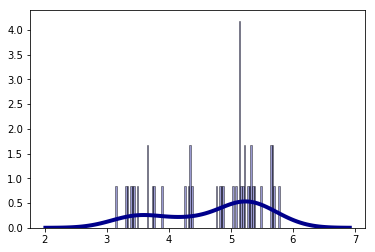

ctg_diffs: avg=4.70, std=0.80, MSE=1021.49, MAE=4.70


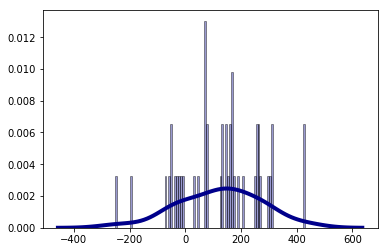

u_diffs: avg=123.89, std=146.54, MSE=1656932.17, MAE=159.48
(1, 45) (1, 45)
R = [[1.         0.42669593]
 [0.42669593 1.        ]]


Text(0,0.5,'u_diff')

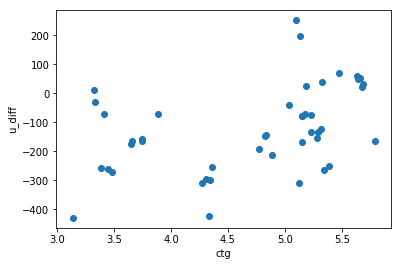

In [45]:
%matplotlib inline
import seaborn as sns

good_ctg_diffs = -ctg_diffs.reshape(1, -1)
good_u_diifs = u_diffs.reshape(1, -1)
print(good_ctg_diffs.shape, good_u_diifs.shape)

def plot_and_print_statistics(diffs, name, bins=100, xlim=None):
    # density plot
    plt.figure()
    sns.distplot(diffs, hist=True, kde=True, 
             bins=bins, # ???
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    if xlim is not None:
        plt.xlim(xlim)
    plt.show()
    
    avg = np.mean(diffs)
    std = np.std(diffs)
    MSE = np.sum(np.square(diffs))
    MAE = np.mean(np.abs(diffs))
    print("{}: avg={:.2f}, std={:.2f}, MSE={:.2f}, MAE={:.2f}".format(name, avg, std, MSE, MAE))


# cost_to_go     ctg_diffs
######################################################################
plot_and_print_statistics(-1*ctg_diffs, "ctg_diffs")

# policy         u_diffs
######################################################################
plot_and_print_statistics(-1*u_diffs.reshape(1, -1), "u_diffs", 
#                           xlim=(-1, 1), 
#                           bins=500
                         )


# Here, I will plot all the VI and Policy things and evaluate correlation
######################################################################
print(good_ctg_diffs.shape, good_u_diifs.shape)
R = np.corrcoef(good_ctg_diffs, good_u_diifs)
print("R = {}".format(R))
plt.scatter(good_ctg_diffs, good_u_diifs)
plt.xlabel("ctg")
plt.ylabel("u_diff")


# Here I will generate the graph of for each subsection of cost_to_go graph,
# what is the distribution of policy outputs?
######################################################################



## Let's see what nets we can fit to this policy!

In [15]:
cost_to_go.shape

(219849,)

In [77]:
count = 0
for val in np.abs(policy.get_output_values()[0]):
    if val > 248:
        count += 1
print("{} / {}".format(count, len(policy.get_output_values()[0])))

127818 / 219849


In [68]:

# SUPER OVERFITTING + L2 + parameter distance metric!
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from nn_system.networks import FC, FCBIG, MLPSMALL, MLP, MLPBIG

# net = FCBIG(n_inputs=4, h_sz=8)
# net = FCBIG(n_inputs=4, h_sz=32) # <--- the one!
# net = MLP(n_inputs=4, h_sz=8)
# net = MLP(n_inputs=4, h_sz=256)#, dropout=True)
# net = MLPBIG(n_inputs=4, h_sz=256)#, dropout=True)

criterion = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(net.parameters(), 2e-6)


EPOCHS = 10

# My data
# np_cost_to_go = cost_to_go.reshape(19, 29, 21, 19)
np_policy = policy.get_output_values().reshape(19, 29, 21, 19)

def my_gen():
    for _ in range(100):
        N = 10000
        xs_idcs        = np.random.choice(19, N).astype(np.int)
        thetas_idcs    = np.random.choice(29, N).astype(np.int)
        xdots_idcs     = np.random.choice(21, N).astype(np.int)
        thetadots_idcs = np.random.choice(19, N).astype(np.int)
        
        xs        = xbins[xs_idcs]
        thetas    = thetabins[thetas_idcs]
        xdots     = xdotbins[xdots_idcs]
        thetadots = thetadotbins[thetadots_idcs]

        inputs = zip(xs, thetas, xdots, thetadots)
        idcs = tuple([xs_idcs, thetas_idcs, xdots_idcs, thetadots_idcs])

#         labels = np_cost_to_go[idcs].reshape(-1, 1).astype(np.double)
        labels = np_policy[idcs].reshape(-1, 1).astype(np.double)

        yield inputs, labels

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(my_gen(), 0):
        # Unpack data
        inputs, labels = data
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)

        # Forward pass
        outputs = net(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 100 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
        running_loss = 0.0

print('Finished Training')


[1,   100] loss: 7.690
[2,   100] loss: 8.204
[3,   100] loss: 8.196
[4,   100] loss: 8.457
[5,   100] loss: 8.856
[6,   100] loss: 8.814
[7,   100] loss: 8.748
[8,   100] loss: 8.172
[9,   100] loss: 8.112
[10,   100] loss: 8.769
Finished Training


In [9]:
# torch.save(net.state_dict(), "NN_MLPBIG_256_fit_to_cartpole_VI.pth")

In [69]:
from nn_system.NNSystem import NNSystem

# Animate the resulting policy.
builder = DiagramBuilder()
tree = RigidBodyTree("/opt/underactuated/src/cartpole/cartpole.urdf",
                     FloatingBaseType.kFixed)
plant = RigidBodyPlant(tree)
plant_system = builder.AddSystem(plant)


# TODO(russt): add wrap-around logic to barycentric mesh
# (so the policy has it, too)
class WrapTheta(VectorSystem):
    def __init__(self):
        VectorSystem.__init__(self, 4, 4)

    def _DoCalcVectorOutput(self, context, input, state, output):
        output[:] = input
        twoPI = 2.*math.pi
#         output[1] = output[1] - twoPI * math.floor(output[1] / twoPI)


wrap = builder.AddSystem(WrapTheta())
builder.Connect(plant_system.get_output_port(0), wrap.get_input_port(0))
vi_policy = builder.AddSystem(NNSystem(net))
# vi_policy = builder.AddSystem(policy)
builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
builder.Connect(vi_policy.get_output_port(0), plant_system.get_input_port(0))

logger = builder.AddSystem(SignalLogger(4))
logger._DeclarePeriodicPublish(0.033333, 0.0)
builder.Connect(plant_system.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)

state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
state.SetFromVector([0., math.pi, 0., 0.])

In [70]:
simulator.StepTo(3)

In [71]:
# Visualize the result as a video.
# vis = PendulumVisualizer()
vis = PlanarRigidBodyVisualizer(tree, xlim=[-12.5, 12.5], ylim=[-1, 2.5])
ani = vis.animate(logger, repeat=True)

# plt.show()λ 
# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())

## Can a net fit to this policy when it only get's stochastic samples of the known optimal policy

## Can traj opt inited with the above fitted optimal policy stay in place / find the optimal off of a small perturbation?